
--- Rastrigin ---
Rastrigin | SGD+Momentum -> 369 iterations
Rastrigin | Adam -> 379 iterations
Rastrigin | RMSProp -> 73 iterations
Rastrigin | UMG -> 1637 iterations


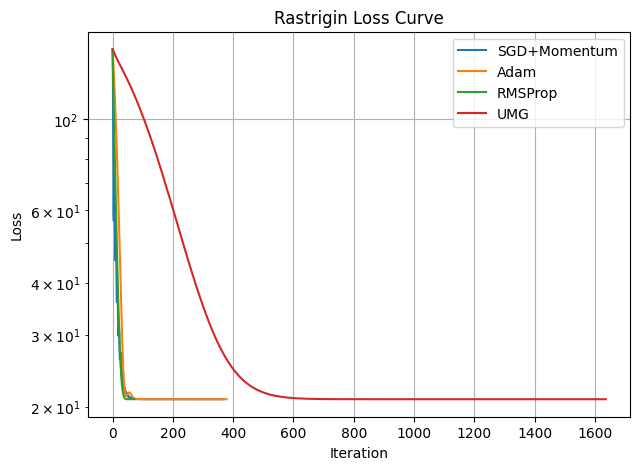


--- Ackley ---
Ackley | SGD+Momentum -> 321 iterations
Ackley | Adam -> 313 iterations
Ackley | RMSProp -> 5000 iterations
Ackley | UMG -> 2959 iterations


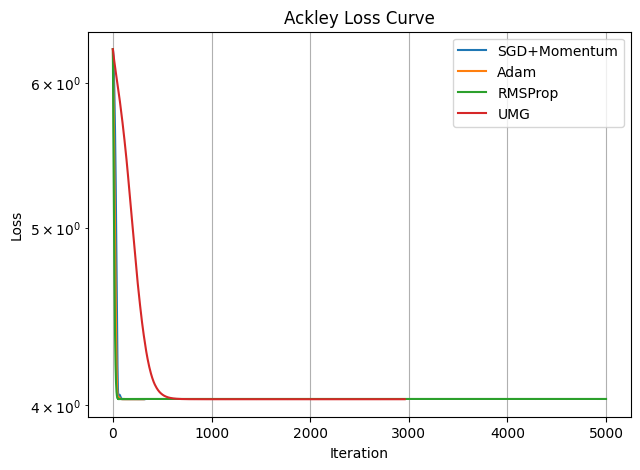


--- Himmelblau ---
Himmelblau | SGD+Momentum -> 327 iterations
Himmelblau | Adam -> 690 iterations
Himmelblau | RMSProp -> 5000 iterations
Himmelblau | UMG -> 5433 iterations


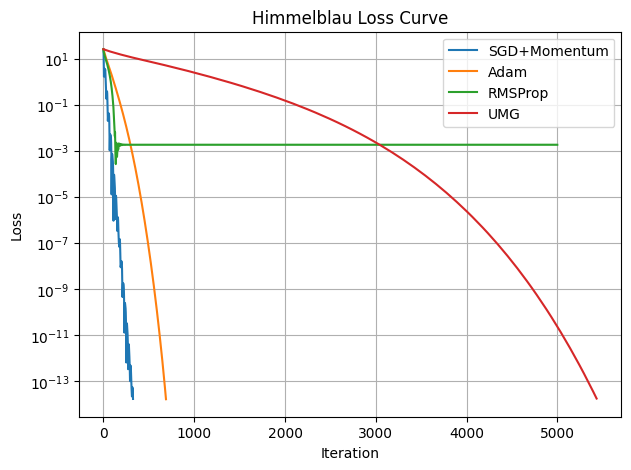

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def adam(f, grad_f, x0, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8,
         tol=1e-6, max_iter=5000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []
    for t in range(1, max_iter+1):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g*g)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.01, beta=0.9, eps=1e-8,
            tol=1e-6, max_iter=5000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        s = beta*s + (1-beta)*(g*g)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i+1, losses

def umg(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999,
        eps=1e-8, scale_bad=0.5, tol=1e-6, max_iter=10000):

    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    prev_diff = np.zeros_like(x) + np.inf
    t = 0
    losses = []

    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)

        g_old = grad_f(x)
        if np.linalg.norm(g_old) < tol:
            break

        t += 1

        # Adam moments
        m = beta1 * m + (1 - beta1) * g_old
        v = beta2 * v + (1 - beta2) * (g_old * g_old)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # tentative update
        x_new = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        # compare gradient directions
        g_new = grad_f(x_new)
        diff_norm = np.linalg.norm(g_new - g_old)

        scale = 1.0 if diff_norm < np.linalg.norm(prev_diff) else scale_bad

        # reinforce/dampen m
        m = beta1 * m + (1 - beta1) * g_old * scale

        prev_diff = g_new - g_old
        x = x_new

    return x, i + 1, losses


# ============================================================
# Runner
# ============================================================
def run_and_plot(f, grad_f, x0, optimizers, name):
    plt.figure(figsize=(7,5))
    for opt_name, opt in optimizers.items():
        x_opt, iters, losses = opt(f, grad_f, x0)
        print(f"{name} | {opt_name} -> {iters} iterations")
        plt.plot(losses, label=opt_name)

    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"{name} Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

# ============================================================
# Run Benchmarks
# ============================================================
optimizers = {
    "SGD+Momentum": lambda f,g,x0: sgd_momentum(f,g,x0,lr=0.01),
    "Adam": lambda f,g,x0: adam(f,g,x0,lr=0.01),
    "RMSProp": lambda f,g,x0: rmsprop(f,g,x0,lr=0.01),
    "UMG": lambda f,g,x0: umg(f,g,x0,lr=0.001)
}

# Rastrigin
print("\n--- Rastrigin ---")
x0 = np.random.randn(10)
run_and_plot(rastrigin_f, rastrigin_grad, x0, optimizers, "Rastrigin")

# Ackley
print("\n--- Ackley ---")
x0 = np.random.randn(10)
run_and_plot(ackley_f, ackley_grad, x0, optimizers, "Ackley")

# Himmelblau
print("\n--- Himmelblau ---")
x0 = np.array([3.0, 3.0])
run_and_plot(himmelblau_f, himmelblau_grad, x0, optimizers, "Himmelblau")


# Benchmark Function Descriptions

## 1. Rastrigin Function
**Type:** Non-convex, multimodal  
**Difficulty:** Many local minima, highly oscillatory  
**Formula:**
f(x) = A·n + Σ [ xᵢ² − A·cos(2πxᵢ) ],  A = 10

**Properties:**
- Very bumpy landscape  
- Many symmetric local minima  
- Global minimum at x = 0  
- Good for testing exploration and escaping shallow minima  

---

## 2. Ackley Function
**Type:** Non-convex, multimodal  
**Difficulty:** Flat region + steep basin  
**Formula:**
f(x) = -a·exp( -b·√( (1/n) Σ xᵢ² ) )  
        - exp( (1/n) Σ cos(c·xᵢ) ) + a + e  
with a = 20, b = 0.2, c = 2π

**Properties:**
- Nearly flat outer region → optimizers stall  
- Rapid drop into a narrow global basin  
- Many cosine-based local minima  
- Standard global optimization benchmark  

---

## 3. Himmelblau Function
**Type:** Non-convex, multiple global minima  
**Difficulty:** Several basins of attraction  
**Formula:**
f(x,y) = (x² + y − 11)² + (x + y² − 7)²

**Properties:**
- Four global minima  
- Several saddle points  
- Good for testing how well optimizers navigate multiple basins  
- Commonly used in visualization studies  

---
